# 라이브러리 호출

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchsummary import summary

import torchvision
import torchvision.transforms as transforms  # 데이터 전처리를 위해 사용하는 라이브러리
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
import copy
from collections import namedtuple # 튜플의 성질을 갖고 있는 자료형이지만 인덱스뿐만 아니라 키 값으로 데이터에 접근할 수 있음.
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 이미지 데이터 전처리

In [3]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train' : transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),   # 이미지를 수직으로 랜덤하게 뒤집기
                transforms.RandomRotation(20),     # -20도에서 20도 사이로 이미지를 랜덤하게 회전
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # 밝기, 대비, 채도를 랜덤하게 변경
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

# 변수에 대한 값 정의

In [4]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [5]:
from google.colab import files
from google.colab import drive

drive.mount('/content/drive')

# 이미지가 저장된 폴더 경로를 지정합니다. 해당 경로는 Google Drive 내에 있는 폴더여야 합니다.
base_folder_path = '/content/drive/MyDrive/파이썬 기반 딥러닝학습/Data/train'

non_demented_folder = 'NonDemented'
verymild_demented_folder = 'VeryMildDemented'
mild_demented_folder = 'MildDemented'
moderate_demented_folder = 'ModerateDemented'

non_demented_image_filepaths = [os.path.join(base_folder_path, non_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, non_demented_folder))]
verymild_demented_image_filepaths = [os.path.join(base_folder_path, verymild_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, verymild_demented_folder))]
mild_demented_image_filepaths = [os.path.join(base_folder_path, mild_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, mild_demented_folder))]
moderate_demented_image_filepaths = [os.path.join(base_folder_path, moderate_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, moderate_demented_folder))]

# 모든 이미지 파일 경로를 하나의 리스트로 합칩니다.
images_filepaths = [*non_demented_image_filepaths, *verymild_demented_image_filepaths, *mild_demented_image_filepaths, *moderate_demented_image_filepaths]

# 이미지 파일을 읽어올 때 유효한 이미지 파일인지 확인합니다.
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

Mounted at /content/drive


In [6]:
len(correct_images_filepaths) # train 데이터셋 파일 갯수.

5121

In [7]:
# random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:4097] # 0.8% -> train
val_images_filepaths = correct_images_filepaths[4097:] # 0.2% -> validation
print(len(train_images_filepaths), len(val_images_filepaths))

4097 1024


# 이미지 데이터 확인

In [8]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

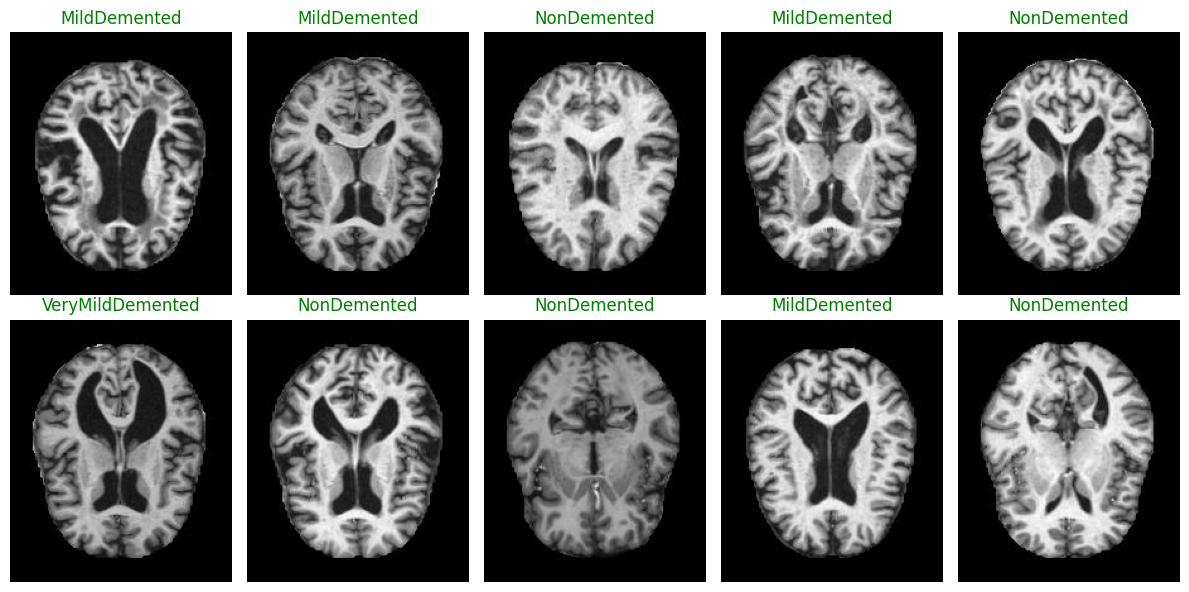

In [9]:
%matplotlib inline

display_image_grid(val_images_filepaths[:10])

# 이미지에 대한 레이블 구분

In [10]:
class alzheimerDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):

        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]

        img = Image.open(img_path).convert('RGB')
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0]
        if label.startswith('nonDem'):
            label = 0
        elif label.startswith('verymildDem'):
            label = 1
        elif label.startswith('mildDem'):
            label = 2
        elif label.startswith('moderateDem'):
            label = 3
        return img_transformed, label

# 이미지 데이터셋 정의

In [11]:
train_dataset = alzheimerDataset(train_images_filepaths,
                                 transform=ImageTransform(size, mean, std),
                                 phase='train')
val_dataset = alzheimerDataset(val_images_filepaths,
                              transform=ImageTransform(size, mean, std),
                              phase='val')

index = 0 # index 0의 이미지 크기와 레이블에 대한 출력
print(train_dataset.__getitem__(index)[0].size()) # 이미지는 컬러(채널 3) 상태에서 224 * 224 크기를 갖고 있음.
print(train_dataset.__getitem__(index)[1]) # 0을 의미하기에 Non Demented

torch.Size([3, 224, 224])
2


# 데이터셋의 데이터를 메모리로 불러오기

In [12]:
train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_iterator, 'val': valid_iterator}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 0, 1, 0, 0, 1, 2, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 2, 1, 2, 1, 2, 2,
        0, 0, 0, 0, 1, 2, 1, 2])


In [13]:
import sys
sys.path.append('/content/drive/MyDrive/파이썬 기반 딥러닝학습')
from ResNet import *
from efficientnet import *

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottlenect(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Ensemble Model

In [14]:
# class EnsembleModel(nn.Module):
#     def __init__(self, efficientnet, resnet):
#         super(EnsembleModel, self).__init__()
#         self.efficientnet = efficientnet
#         self.resnet = resnet
#         self.fc = nn.Linear(OUTPUT_DIM * 2, OUTPUT_DIM)  # OUTPUT_DIM은 최종 클래스 수입니다.

#     def forward(self, x):
#         # EfficientNet 및 ResNet의 각각의 forward 호출
#         efficientnet_output = self.efficientnet(x)
#         resnet_output = self.resnet(x)

#         # 만약 출력이 튜플이라면, 첫 번째 요소만 사용합니다.
#         if isinstance(efficientnet_output, tuple):
#             efficientnet_output = efficientnet_output[0]

#         if isinstance(resnet_output, tuple):
#             resnet_output = resnet_output[0]

#         # EfficientNet 및 ResNet의 출력을 결합
#         combined_output = torch.cat([efficientnet_output, resnet_output], dim=1)

#         # 최종 선형 레이어를 통해 최종 예측 생성
#         final_output = self.fc(combined_output)

#         return final_output


# # EfficientNet과 ResNet 모델 생성
# efficientnet_model = efficientnet_b0(num_classes=OUTPUT_DIM)
# resnet_model = ResNet(resnet152_config, OUTPUT_DIM)

# # 앙상블 모델 생성
# ensemble_model = EnsembleModel(efficientnet_model, resnet_model)

# # 모델 출력 확인
# print(ensemble_model)

In [15]:
class EnsembleModel(nn.Module):
    def __init__(self, efficientnet, resnet, output_dim):
        super(EnsembleModel, self).__init__()
        self.efficientnet = efficientnet
        self.resnet = resnet
        self.fc = nn.Linear(output_dim * 2, output_dim)  # output_dim은 최종 클래스 수입니다.
        self.softmax = nn.Softmax(dim=1)  # Softmax 활성화 함수 추가

    def forward(self, x):
        # EfficientNet 및 ResNet의 각각의 forward 호출
        efficientnet_output = self.efficientnet(x)
        resnet_output = self.resnet(x)

        # 만약 출력이 튜플이라면, 첫 번째 요소만 사용합니다.
        if isinstance(efficientnet_output, tuple):
            efficientnet_output = efficientnet_output[0]

        if isinstance(resnet_output, tuple):
            resnet_output = resnet_output[0]

        # EfficientNet 및 ResNet의 출력을 결합
        combined_output = torch.cat([efficientnet_output, resnet_output], dim=1)

        # 최종 선형 레이어를 통해 최종 예측 생성
        final_output = self.fc(combined_output)

        # Softmax 활성화 함수를 통해 확률 분포로 변환
        final_output = self.softmax(final_output)

        return final_output

# EfficientNet과 ResNet 모델 생성
efficientnet_model = efficientnet_b0(num_classes=OUTPUT_DIM)
resnet_model = ResNet(resnet152_config, OUTPUT_DIM)

# 앙상블 모델 생성
ensemble_model = EnsembleModel(efficientnet_model, resnet_model, OUTPUT_DIM)

# 모델 출력 확인
print(ensemble_model)

EnsembleModel(
  (efficientnet): EfficientNet(
    (upsample): Upsample(scale_factor=1.0, mode='bilinear')
    (stage1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    )
    (stage2): Sequential(
      (0): SepConv(
        (residual): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
          (2): Swish(
            (sigmoid): Sigmoid()
          )
        )
        (se): SEBlock(
          (squeeze): AdaptiveAvgPool2d(output_size=(1, 1))
          (excitation): Sequential(
            (0): Linear(in_features=32, out_features=128, bias=True)
            (1): Swish(
              (sigmoid): Sigmoid()
            )
            (2): Linear(in_features=128, out_features=32, bias=Tru

In [16]:
from torch import nn
import torch

class EnsembleModel(nn.Module):
    def __init__(self, efficientnet, resnet, output_dim):
        super(EnsembleModel, self).__init__()
        self.efficientnet = efficientnet
        self.resnet = resnet
        self.fc = nn.Linear(output_dim * 2, output_dim)  # output_dim은 최종 클래스 수입니다.
        self.softmax = nn.Softmax(dim=1)  # Softmax 활성화 함수 추가

    def forward(self, x):
        # EfficientNet 및 ResNet의 각각의 forward 호출
        efficientnet_output = self.efficientnet(x)
        resnet_output = self.resnet(x)

        # 만약 출력이 튜플이라면, 첫 번째 요소만 사용합니다.
        if isinstance(efficientnet_output, tuple):
            efficientnet_output = efficientnet_output[0]

        if isinstance(resnet_output, tuple):
            resnet_output = resnet_output[0]

        # EfficientNet 및 ResNet의 출력을 결합
        combined_output = torch.cat([efficientnet_output, resnet_output], dim=1)

        # 최종 선형 레이어를 통해 최종 예측 생성
        final_output = self.fc(combined_output)

        # Softmax 활성화 함수를 통해 확률 분포로 변환
        final_output = self.softmax(final_output)

        return final_output

# EfficientNet과 ResNet 모델 생성
efficientnet_model = EfficientNet(num_classes=OUTPUT_DIM)
resnet_model = ResNet(resnet50_config, OUTPUT_DIM)

# 앙상블 모델 생성
ensemble_model = EnsembleModel(efficientnet_model, resnet_model, OUTPUT_DIM)

# 모델 출력 확인
print(ensemble_model)

EnsembleModel(
  (efficientnet): EfficientNet(
    (upsample): Upsample(scale_factor=1.0, mode='bilinear')
    (stage1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    )
    (stage2): Sequential(
      (0): SepConv(
        (residual): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
          (2): Swish(
            (sigmoid): Sigmoid()
          )
        )
        (se): SEBlock(
          (squeeze): AdaptiveAvgPool2d(output_size=(1, 1))
          (excitation): Sequential(
            (0): Linear(in_features=32, out_features=128, bias=True)
            (1): Swish(
              (sigmoid): Sigmoid()
            )
            (2): Linear(in_features=128, out_features=32, bias=Tru

# 옵티마이저와 손실 함수 정의

In [17]:
optimizer = optim.Adam(ensemble_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

ensemble_model = ensemble_model.to(device)
criterion = criterion.to(device)

# 모델 학습 정확도 측정 함수 정의

In [18]:
def calculate_topk_accuracy(y_pred, y, k=2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, dim=1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim=True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size

    return acc_1, acc_k

In [19]:
from sklearn.metrics import roc_auc_score

# def calculate_roc_auc(y_true, y_pred_probs):
#     # Convert one-hot encoded labels to class indices
#     y_true_indices = np.argmax(y_true, axis=1)

#     # Calculate ROC AUC for multi-class classification
#     roc_auc = roc_auc_score(y_true_indices, y_pred_probs, multi_class='ovr')

#     return roc_auc

In [30]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def calculate_roc_auc(y_true, y_score):
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_true = lb.transform(y_true)

    # 예외 처리 추가
    try:
        return roc_auc_score(y_true, y_score, multi_class='ovo', average='macro')
    except ValueError:
        return None  # or any default value

# 모델 학습 함수 정의

In [31]:
# import torch.nn.functional as F

# def train(model, iterator, optimizer, criterion, device):
#     epoch_loss = 0
#     epoch_acc_1 = 0
#     epoch_acc_5 = 0

#     model.train()

#     for (x, y) in iterator:
#         x = x.to(device)
#         y = y.to(device)

#         optimizer.zero_grad()
#         y_pred = model(x)

#         # Check the shape of y_pred
#         if isinstance(y_pred, list):
#             y_pred = y_pred[0]

#         # Ensure the target has the correct shape
#         y = y.unsqueeze(1)  # Add an extra dimension
#         y = y.repeat(1, y_pred.shape[1])  # Repeat to match the number of classes

#         # Convert y to class indices
#         y_indices = torch.argmax(y, dim=1)

#         loss = criterion(y_pred, y_indices)

#         acc_1, acc_5 = calculate_topk_accuracy(y_pred, y_indices)
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()
#         epoch_acc_1 += acc_1.item()
#         epoch_acc_5 += acc_5.item()

#     epoch_loss /= len(iterator)
#     epoch_acc_1 /= len(iterator)
#     epoch_acc_5 /= len(iterator)

#     return epoch_loss, epoch_acc_1, epoch_acc_5

In [45]:
from torch.nn.functional import one_hot

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    epoch_roc_auc = 0
    roc_auc_count = 0  # roc_auc가 None이 아닌 경우를 세는 카운터 추가

    model.train()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)

        if isinstance(y_pred, list):
            y_pred = y_pred[0]

        y = one_hot(y, num_classes=4)

        # y = y.unsqueeze(1)
        # y = y.repeat(1, y_pred.shape[1])

        y_indices = torch.argmax(y, dim=1)

        loss = criterion(y_pred, y_indices)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y_indices)
        roc_auc = calculate_roc_auc(y.detach().cpu().numpy(), torch.softmax(y_pred, dim=1).detach().cpu().numpy())

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

        # roc_auc가 None이 아닌 경우에만 epoch_roc_auc에 더하고 카운터 증가
        if roc_auc is not None:
            epoch_roc_auc += roc_auc
            roc_auc_count += 1

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    # epoch_roc_auc /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5, epoch_roc_auc / roc_auc_count


In [46]:
# def train(model, iterator, optimizer, criterion, device):
#     epoch_loss = 0
#     epoch_acc_1 = 0
#     epoch_acc_5 = 0
#     epoch_roc_auc = 0
#     roc_auc_count = 0  # roc_auc가 None이 아닌 경우를 세는 카운터 추가

#     model.train()

#     for (x, y) in iterator:
#         x = x.to(device)
#         y = y.to(device)

#         optimizer.zero_grad()

#         y_pred = model(x)

#         loss = criterion(y_pred, y)

#         acc_1, acc_5 = calculate_accuracy(y_pred, y)

#         roc_auc = calculate_roc_auc(y.cpu(), y_pred.detach().cpu())  # ROC AUC 계산

#         loss.backward()

#         optimizer.step()

#         epoch_loss += loss.item()
#         epoch_acc_1 += acc_1.item()
#         epoch_acc_5 += acc_5.item()

#         # roc_auc가 None이 아닌 경우에만 epoch_roc_auc에 더하고 카운터 증가
#         if roc_auc is not None:
#             epoch_roc_auc += roc_auc
#             roc_auc_count += 1

#     # epoch_roc_auc를 실제로 계산된 ROC AUC의 수로 나눔
#     return epoch_loss / len(iterator), epoch_acc_1 / len(iterator), epoch_acc_5 / len(iterator), epoch_roc_auc / roc_auc_count


# 모델 평가 함수 정의

In [47]:
# def evaluate(model, iterator, criterion, device):
#     epoch_loss = 0
#     epoch_acc_1 = 0
#     epoch_acc_5 = 0

#     model.eval()

#     with torch.no_grad():
#         for (x, y) in iterator:
#             x = x.to(device)
#             y = y.to(device)

#             y_pred = model(x)

#             # Check the shape of y_pred
#             if isinstance(y_pred, list):
#                 y_pred = y_pred[0]

#             # Ensure the target has the correct shape
#             y = y.unsqueeze(1)  # Add an extra dimension
#             y = y.repeat(1, y_pred.shape[1])  # Repeat to match the number of classes

#             # Convert y to class indices
#             y_indices = torch.argmax(y, dim=1)

#             loss = criterion(y_pred, y_indices)

#             acc_1, acc_5 = calculate_topk_accuracy(y_pred, y_indices)

#             epoch_loss += loss.item()
#             epoch_acc_1 += acc_1.item()
#             epoch_acc_5 += acc_5.item()

#     epoch_loss /= len(iterator)
#     epoch_acc_1 /= len(iterator)
#     epoch_acc_5 /= len(iterator)

#     return epoch_loss, epoch_acc_1, epoch_acc_5


In [48]:
# def evaluate(model, iterator, criterion, device, return_predictions=False):
#     epoch_loss = 0
#     epoch_acc_1 = 0
#     epoch_acc_5 = 0
#     valid_labels = []  # to collect true labels
#     valid_probs = []   # to collect predicted probabilities

#     model.eval()

#     with torch.no_grad():
#         for (x, y) in iterator:
#             x = x.to(device)
#             y = y.to(device)

#             y_pred = model(x)

#             # Check the shape of y_pred
#             if isinstance(y_pred, list):
#                 y_pred = y_pred[0]

#             # Ensure the target has the correct shape
#             y = y.unsqueeze(1)  # Add an extra dimension
#             y = y.repeat(1, y_pred.shape[1])  # Repeat to match the number of classes

#             # Convert y to class indices
#             y_indices = torch.argmax(y, dim=1)

#             loss = criterion(y_pred, y_indices)

#             acc_1, acc_5 = calculate_topk_accuracy(y_pred, y_indices)

#             # Collect true labels and predicted probabilities
#             valid_labels.extend(y.cpu().numpy())
#             valid_probs.extend(torch.softmax(y_pred, dim=1).cpu().numpy())

#             epoch_loss += loss.item()
#             epoch_acc_1 += acc_1.item()
#             epoch_acc_5 += acc_5.item()

#     epoch_loss /= len(iterator)
#     epoch_acc_1 /= len(iterator)
#     epoch_acc_5 /= len(iterator)

#     if return_predictions:
#         return epoch_loss, epoch_acc_1, epoch_acc_5, np.array(valid_labels), np.array(valid_probs)
#     else:
#         return epoch_loss, epoch_acc_1, epoch_acc_5

In [49]:
def evaluate(model, iterator, criterion, device, return_predictions=False):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    epoch_roc_auc = 0
    roc_auc_count = 0  # roc_auc가 None이 아닌 경우를 세는 카운터 추가

    valid_labels = []
    valid_probs = []

    model.eval()

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            if isinstance(y_pred, list):
                y_pred = y_pred[0]

            y = one_hot(y, num_classes=4)

            # y = y.unsqueeze(1)
            # y = y.repeat(1, y_pred.shape[1])

            y_indices = torch.argmax(y, dim=1)

            loss = criterion(y_pred, y_indices)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y_indices)
            roc_auc = calculate_roc_auc(y.detach().cpu().numpy(), torch.softmax(y_pred, dim=1).detach().cpu().numpy())

            valid_labels.extend(y.cpu().numpy())
            valid_probs.extend(torch.softmax(y_pred, dim=1).cpu().numpy())

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

            # roc_auc가 None이 아닌 경우에만 epoch_roc_auc에 더하고 카운터 증가
            if roc_auc is not None:
                epoch_roc_auc += roc_auc
                roc_auc_count += 1

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    # epoch_roc_auc /= len(iterator)

    if return_predictions:
        return epoch_loss, epoch_acc_1, epoch_acc_5, epoch_roc_auc / roc_auc_count, np.array(valid_labels), np.array(valid_probs)
    else:
        return epoch_loss, epoch_acc_1, epoch_acc_5, epoch_roc_auc / roc_auc_count


# 모델 학습 시간 측정 함수 정의

In [50]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time - (elapsed_mins*60))

    return elapsed_mins, elapsed_secs

# 모델 학습

In [51]:
# best_valid_loss = float('inf')
# EPOCHS = 10

# train_accuracy = []
# valid_accuracy = []

# for epoch in range(EPOCHS):
#     start_time = time.monotonic()

#     train_loss, train_acc_1, train_acc_5 = train(ensemble_model, train_iterator, optimizer, criterion, device)
#     valid_loss, valid_acc_1, valid_acc_5 = evaluate(ensemble_model, valid_iterator, criterion, device)

#     # Append train and valid accuracy to the lists
#     train_accuracy.append(train_acc_1)
#     valid_accuracy.append(valid_acc_1)

#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), '/content/drive/MyDrive/EfficientNet&ResNet_Ensemble1-model.pt')


#     end_time = time.monotonic()
#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)

#     print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
#          f'Train Acc @5: {train_acc_5*100:6.2f}%')
#     print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
#          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')


In [52]:
# from sklearn.metrics import roc_auc_score

# best_valid_loss = float('inf')
# EPOCHS = 10
# num_classes = 4

# train_accuracy = []
# valid_accuracy = []
# roc_auc_list_epoch = []

# for epoch in range(EPOCHS):
#     start_time = time.monotonic()

#     train_loss, train_acc_1, train_acc_5 = train(ensemble_model, train_iterator, optimizer, criterion, device)
#     valid_loss, valid_acc_1, valid_acc_5, valid_labels, valid_preds = evaluate(ensemble_model, valid_iterator, criterion, device, return_predictions=True)

#     # Append train and valid accuracy to the lists
#     train_accuracy.append(train_acc_1)
#     valid_accuracy.append(valid_acc_1)

#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(ensemble_model.state_dict(), '/content/drive/MyDrive/EfficientNet&ResNet_Ensemble1-model.pt')

#     # Ensure valid_labels and valid_preds are 2D arrays
#     valid_labels = valid_labels.reshape(-1, num_classes)
#     valid_preds = valid_preds.reshape(-1, num_classes)

#     # Print shapes
#     print(f"valid_labels shape: {valid_labels.shape}")
#     print(f"valid_preds shape: {valid_preds.shape}")

#     # Calculate ROC AUC for each class
#     roc_auc_list = []
#     for i in range(num_classes):
#         print(f"Processing class {i + 1}")
#         print(f"valid_labels[:, {i}]: {valid_labels[:, i]}")
#         print(f"valid_preds[:, {i}]: {valid_preds[:, i]}")

#         roc_auc_i = roc_auc_score(valid_labels[:, i], valid_preds[:, i])
#         roc_auc_list.append(roc_auc_i)

#     roc_auc_list_epoch.append(roc_auc_list)

#     end_time = time.monotonic()
#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)

#     print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
#          f'Train Acc @5: {train_acc_5*100:6.2f}%')
#     print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
#          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')
#     print(f'\tROC AUC for each class: {np.mean(roc_auc_list):.3f}')

# # Plotting train and valid accuracy
# plt.plot(train_accuracy, label='Train Accuracy')
# plt.plot(valid_accuracy, label='Valid Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Plotting ROC AUC for each class
# roc_auc_array = np.array(roc_auc_list_epoch)
# for i in range(num_classes):
#     plt.plot(roc_auc_array[:, i], label=f'Class {i + 1} ROC AUC')

# plt.xlabel('Epoch')
# plt.ylabel('ROC AUC')
# plt.legend()
# plt.show()


Epoch: 01 | Epoch Time: 1m 33s
	Train Loss: 1.217 | Train Top-1 Acc: 51.07% | Train Top-5 Acc: 79.07% | Train ROC AUC: 0.573
	Valid Loss: 1.196 | Valid Top-1 Acc: 52.25% | Valid Top-5 Acc: 81.45% | Valid ROC AUC: 0.613
Epoch: 02 | Epoch Time: 1m 34s
	Train Loss: 1.186 | Train Top-1 Acc: 53.32% | Train Top-5 Acc: 80.69% | Train ROC AUC: 0.625
	Valid Loss: 1.257 | Valid Top-1 Acc: 48.63% | Valid Top-5 Acc: 83.59% | Valid ROC AUC: 0.504
Epoch: 03 | Epoch Time: 1m 33s
	Train Loss: 1.180 | Train Top-1 Acc: 54.68% | Train Top-5 Acc: 81.71% | Train ROC AUC: 0.655
	Valid Loss: 1.266 | Valid Top-1 Acc: 47.75% | Valid Top-5 Acc: 83.98% | Valid ROC AUC: 0.500
Epoch: 04 | Epoch Time: 1m 33s
	Train Loss: 1.171 | Train Top-1 Acc: 55.23% | Train Top-5 Acc: 82.36% | Train ROC AUC: 0.633
	Valid Loss: 1.162 | Valid Top-1 Acc: 56.45% | Valid Top-5 Acc: 83.89% | Valid ROC AUC: 0.600
Epoch: 05 | Epoch Time: 1m 34s
	Train Loss: 1.162 | Train Top-1 Acc: 56.52% | Train Top-5 Acc: 84.35% | Train ROC AUC: 0.624

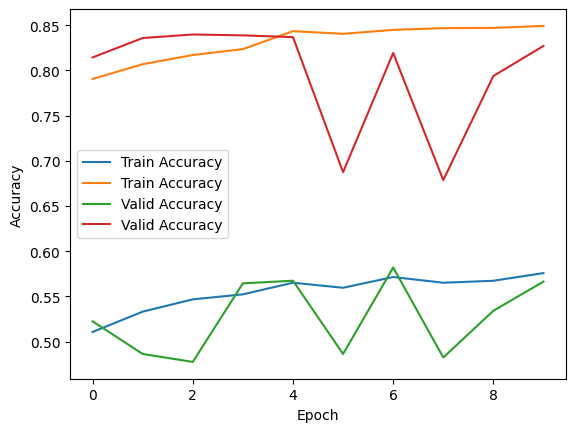

IndexError: ignored

In [53]:
from sklearn.metrics import roc_auc_score

best_valid_loss = float('inf')
EPOCHS = 10
num_classes = 4

train_accuracy = []
valid_accuracy = []
roc_auc_list_epoch = []

for epoch in range(EPOCHS):
    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5, train_roc_auc = train(ensemble_model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5, valid_roc_auc, valid_labels, valid_preds = evaluate(ensemble_model, valid_iterator, criterion, device, return_predictions=True)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Save the model if validation loss decreased
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(ensemble_model.state_dict(), '/content/drive/MyDrive/EfficientNet&ResNet_Ensemble1-model.pt')

    train_accuracy.append((train_acc_1, train_acc_5))
    valid_accuracy.append((valid_acc_1, valid_acc_5))
    roc_auc_list_epoch.append(valid_roc_auc)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Top-1 Acc: {train_acc_1*100:.2f}% | Train Top-5 Acc: {train_acc_5*100:.2f}% | Train ROC AUC: {train_roc_auc:.3f}')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Top-1 Acc: {valid_acc_1*100:.2f}% | Valid Top-5 Acc: {valid_acc_5*100:.2f}% | Valid ROC AUC: {valid_roc_auc:.3f}')

# Plotting train and valid accuracy
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(valid_accuracy, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting ROC AUC for each class
roc_auc_array = np.array(roc_auc_list_epoch)
for i in range(num_classes):
    plt.plot(roc_auc_array[:, i], label=f'Class {i + 1} ROC AUC')

plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# # Plotting train and valid accuracy
# plt.plot(train_accuracy, label='Train Accuracy')
# plt.plot(valid_accuracy, label='Valid Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()